# importing necessary libraries

In [1]:
import os, random                                                                   # for handelling the files
import numpy as np                                                                  # working with arrays and data manupilation
import pandas as pd
import json
import matplotlib.pyplot as plt                                                     # plottting                

from glob import glob                                                               # for handelling file paths
from pathlib import Path                                                            # for handelling file paths
from natsort import natsorted                                                       # for sorting files
from tqdm.auto import tqdm                                                          # for asthetic for loops :)
from collections import Counter                                                     # drawing charts
import seaborn as sns

from sklearn.model_selection import train_test_split                                # splitting the dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
import torch, torchvision, torchmetrics, torchinfo
import torch.optim as optim                                                         # optimizer
import torch.nn.functional as F                                                     # loss function

from torch import nn                                                                # building neural networks
from torch.utils.data import Dataset                                                # building dataset objects
from torch.utils.data import DataLoader                                             # building data loaders to feed the data to model
from torch.utils.tensorboard import SummaryWriter                                   # for tracking model performance(easy to use)
from torchvision import transforms                                                  # for changes to the dataset content
from torchinfo import summary                                                       # gives a summery of model structure

In [3]:
import cv2
import mediapipe as mp

In [4]:
# here I am checking the cuda device available
if torch.cuda.is_available():
    print("Cuda is available.")
    print(f"Current Device: {torch.cuda.current_device()}, Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Cuda is available.
Current Device: 0, Device Name: NVIDIA GeForce RTX 3060 Laptop GPU


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
holistic_model= mp.solutions.holistic
draw_utils= mp.solutions.drawing_utils

I decided to use **LSA64: A Dataset for Argentinian Sign Language**:<br>
**The sign database** for the Argentinian Sign Language, created with the goal of producing a dictionary for LSA and training an automatic sign recognizer, **includes 3200 videos where 10 non-expert subjects executed 5 repetitions of 64 different types of signs**. Signs were selected among the most commonly used ones in the LSA lexicon, including both verbs and nouns.<br>

- I tried to capture detections for the entire dataset but it took around 3 hours. and at the end i had to change the code because i forgot to add a list that would represent the essence of the video in terms of being a sequence of detected frame landmarks.

- As seen in the picture below a good number of video samples involve using right hand. after my first experiment as a concept I decided to eliminate detections for left hands because i was only using the first 10 words. and leaving left hand detections created a lot of zeros which i believe were effecting my lstm perfomance.


![Image Description](lsa64_raw/Images/datasetgeneralinfo.png)

# Function to extract detections from all videos in our dataset

In [7]:
def get_landmarks(root: str, class_names):
    
    all_video_paths= natsorted([str(p) for p in Path(root).glob("**/*.mp4")])
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    none_cv2_video_paths= []
    detections= []
    labels= []
    frame_numbers= 30
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        for video_path in tqdm(all_video_paths, desc="Processing videos"):
            cap = cv2.VideoCapture(video_path)              # Read each video using cv2
            if not cap.isOpened():                          # if cv2 can't read the video
                none_cv2_video_paths.append(video_path)     # save the video path
            else:                                           # if cap can read the video
                total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
                frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
                video_detections= []
                for idx in frame_idxs_to_process:
                    cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                    ret, frame= cap.read()
            
                    result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                    pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                    #face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                    #lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                    rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                    detection= np.concatenate((pose, rh))
                    label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                    video_detections.append(detection)

                
                detections.append(video_detections)    
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                labels.append(label)
   
            cap.release()
        
    return detections, labels, len(all_video_paths),len(none_cv2_video_paths)

In [8]:
root= 'lsa64_raw/all'
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy', 'Son', 'Man', 'Away', 'Drawer', 'Born', 'Learn',
              'Call', 'Skimmer', 'Bitter', 'Sweet milk', 'Milk', 'Water', 'Food', 'Argentina',
              'Uruguay', 'Country', 'Last name', 'Where', 'Mock', 'Birthday', 'Breakfast', 'Photo',
              'Hungry', 'Map', 'Coin', 'Music', 'Ship', 'None', 'Name', 'Patience',
              'Perfume', 'Deaf', 'Trap', 'Rice', 'Barbecue', 'Candy', 'Chewing-gum', 'Spaghetti',
              'Yogurt', 'Accept', 'Thanks', 'Shut down', 'Appear', 'To land', 'Catch', 'Help',
              'Dance', 'Bathe', 'Buy', 'Copy', 'Run', 'Realize', 'Give', 'Find']

In [9]:
root= 'lsa64_raw/some'
class_names= ['Opaque', 'Red', 'Green', 'Yellow', 'Bright', 'Light-blue', 'Colors', 'Pink',
              'Women', 'Enemy']

In [ ]:
result= get_landmarks(root, class_names)

# Saving detections for later use

In [10]:
save_directory= 'lsa64_raw/some_results/'

In [76]:
np.save(os.path.join(save_directory, 'detections(no_left_handno_face).npy'), np.array(result[0]))     # saving detection 
with open(os.path.join(save_directory, 'labels(no_left_handno_face).json'), 'w') as file:
    json.dump(result[1], file)                                                   # saving labels

NameError: name 'result' is not defined

# Loading detections and labels and doing the split

In [25]:
detections= np.load(os.path.join(save_directory, 'detections(no_left_hand).npy'), allow_pickle=True)
with open(os.path.join(save_directory, 'labels(no_left_hand).json'), 'r') as file:
    labels= json.load(file)

In [26]:
labels

['Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Opaque',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Red',
 'Green',
 'Green',
 'Green',
 'Green',
 'Green',


In [12]:
#splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(detections, labels, test_size=0.2, random_state=42, stratify=labels)

In [13]:
# changing X to tensors
X_train, X_test= torch.tensor(X_train, dtype=torch.float32) , torch.tensor(X_test, dtype=torch.float32)
# changing y to one hot key + tensor
label_map= {label: num for num, label in enumerate(class_names)}
y_train= [label_map[label] for label in y_train]
y_test= [label_map[label] for label in y_test]

y_train= torch.tensor(y_train, dtype=torch.long)
y_test= torch.tensor(y_test, dtype=torch.long)

In [14]:
X_train.shape, X_test.shape

(torch.Size([400, 30, 1599]), torch.Size([100, 30, 1599]))

In [19]:
y_test

tensor([7, 2, 7, 4, 6, 0, 5, 9, 1, 8, 3, 5, 9, 3, 7, 2, 5, 6, 0, 9, 9, 5, 1, 1,
        6, 3, 9, 6, 8, 7, 5, 3, 2, 5, 4, 2, 9, 8, 4, 7, 8, 1, 6, 1, 6, 2, 2, 6,
        0, 4, 5, 6, 5, 3, 3, 6, 6, 1, 0, 7, 1, 4, 5, 5, 1, 3, 4, 1, 0, 8, 0, 8,
        8, 7, 4, 8, 2, 2, 2, 4, 4, 0, 9, 8, 7, 1, 4, 8, 3, 9, 9, 0, 2, 7, 3, 0,
        0, 3, 7, 9])

In [15]:
#is_close = np.allclose(detections_tensor[0].numpy(), detections[0], atol=1e-9)
#is_close_pytorch = torch.allclose(detections_tensor[0], torch.tensor(detections[0], dtype=detections_tensor.dtype), atol=1e-9)

# Building dataset class and Building dataloader class

In [16]:
class CustomDataset(Dataset):
    def __init__(self,features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

# Building LSTM Model

In [17]:
import torch
import torch.nn as nn

class SequentialModel(nn.Module):
    def __init__(self):
        super(SequentialModel, self).__init__()
        # Define the LSTM layers
        self.lstm1 = nn.LSTM(input_size=1599, hidden_size=64, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=64, hidden_size=64, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)

        # Define the Dense layers
        self.dense1 = nn.Linear(32, 32)
        self.dense2 = nn.Linear(32, 32)
        self.dense3 = nn.Linear(32, 10)

        # Define activation functions
        self.relu = nn.ReLU()

    def forward(self, x):
        x, (hn, cn) = self.lstm1(x)
        x = self.relu(x)
        x, (hn, cn) = self.lstm2(x)
        x = self.relu(x)
        x, (hn, cn) = self.lstm3(x)
        x = self.relu(x)

        x = x[:, -1, :] # here we make x the last prediction of the model beacuse i want to do classification

        x = self.relu(self.dense1(x))
        x = self.relu(self.dense2(x))
        x = self.dense3(x) 
        return x

In [33]:
test_model= SequentialModel()
summary(test_model, input_size=(1, 30, 1599))

Layer (type:depth-idx)                   Output Shape              Param #
SequentialModel                          [1, 10]                   --
├─LSTM: 1-1                              [1, 30, 64]               426,240
├─ReLU: 1-2                              [1, 30, 64]               --
├─LSTM: 1-3                              [1, 30, 64]               33,280
├─ReLU: 1-4                              [1, 30, 64]               --
├─LSTM: 1-5                              [1, 30, 32]               12,544
├─ReLU: 1-6                              [1, 30, 32]               --
├─Linear: 1-7                            [1, 32]                   1,056
├─ReLU: 1-8                              [1, 32]                   --
├─Linear: 1-9                            [1, 32]                   1,056
├─ReLU: 1-10                             [1, 32]                   --
├─Linear: 1-11                           [1, 10]                   330
Total params: 474,506
Trainable params: 474,506
Non-trainable par

# initializing models and datasets

In [80]:
train_dataset= CustomDataset(X_train, y_train)
test_dataset= CustomDataset(X_test, y_test)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=8, num_workers=0, shuffle=True) 
test_dataloader = DataLoader(dataset=test_dataset, batch_size=8, num_workers=0, shuffle=False) 

lstm_model= SequentialModel().to(device)

'''
transformer_model= torch.nn.Transformer(d_model=1599,
                                        nhead=7,
                                        num_encoder_layers=6, num_decoder_layers=6,
                                        dim_feedforward=40,
                                        dropout=0.1,
                                        activation='relu',
                                        custom_encoder=None, custom_decoder=None, 
                                        layer_norm_eps=1e-05, 
                                        batch_first=True, norm_first=False,
                                        bias=True, device=None, dtype=None).to(device)
'''

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.0001)

def calculate_accuracy(y_pred, y_true):
    _, predictions = torch.max(y_pred, 1)
    correct = (predictions == y_true).float()
    accuracy = correct.sum() / len(correct)
    return accuracy

In [81]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 500
for epoch in range(num_epochs):
    lstm_model.train()
    train_loss = 0.0
    train_accuracy = 0.0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = lstm_model(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_accuracy += calculate_accuracy(outputs, labels)
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(train_accuracy / len(train_dataloader))

    all_preds = []
    all_labels = []
    
    lstm_model.eval()
    test_loss = 0.0
    test_accuracy = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = lstm_model(inputs)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_accuracy += calculate_accuracy(outputs, labels)

            _, preds = torch.max(outputs, 1)  # Get the predicted labels
            all_preds.extend(preds.view(-1).cpu().numpy())  # Store predictions
            all_labels.extend(labels.view(-1).cpu().numpy())  # Store true labels

            
    
    test_losses.append(test_loss / len(test_dataloader))
    test_accuracies.append(test_accuracy / len(test_dataloader))
    
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Accuracy: {test_accuracies[-1]}')

Epoch 1, Train Loss: 2.3045237684249877, Test Loss: 2.3041753585521993, Train Accuracy: 0.09999999403953552, Test Accuracy: 0.10576923191547394
Epoch 2, Train Loss: 2.303909192085266, Test Loss: 2.303828422839825, Train Accuracy: 0.09999999403953552, Test Accuracy: 0.10576923191547394
Epoch 3, Train Loss: 2.3033400869369505, Test Loss: 2.3028114025409403, Train Accuracy: 0.09999999403953552, Test Accuracy: 0.10576923191547394
Epoch 4, Train Loss: 2.302236933708191, Test Loss: 2.301171431174645, Train Accuracy: 0.10499999672174454, Test Accuracy: 0.10576923191547394
Epoch 5, Train Loss: 2.299442858695984, Test Loss: 2.295574298271766, Train Accuracy: 0.10749999433755875, Test Accuracy: 0.14423076808452606
Epoch 6, Train Loss: 2.2927767181396486, Test Loss: 2.288471221923828, Train Accuracy: 0.17499999701976776, Test Accuracy: 0.19230769574642181
Epoch 7, Train Loss: 2.2873435020446777, Test Loss: 2.2783509767972507, Train Accuracy: 0.17499999701976776, Test Accuracy: 0.20192308723926544

In [82]:
train_accuracies_cpu = [x.cpu().item() for x in train_accuracies]
test_accuracies_cpu = [x.cpu().item() for x in test_accuracies]

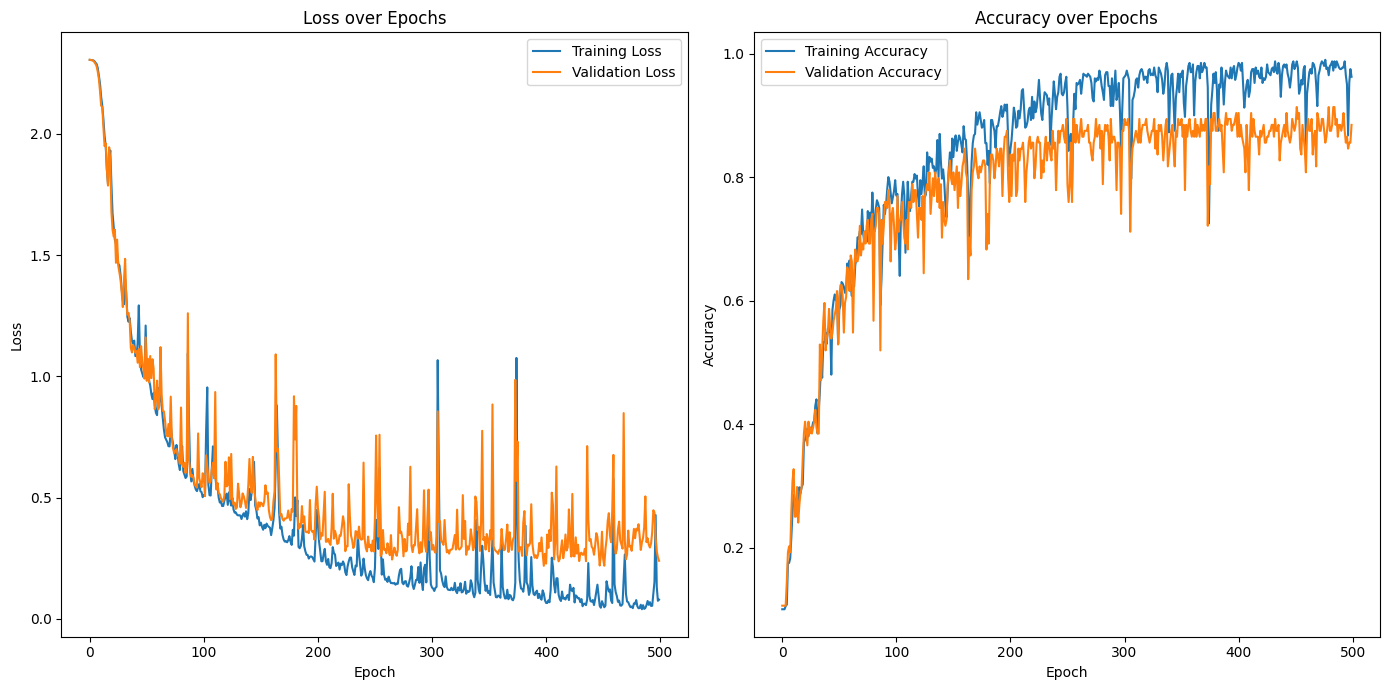

In [83]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')  # or use train_losses_cpu if converted
plt.plot(test_losses, label='Validation Loss')  # or use test_losses_cpu if converted
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_cpu, label='Training Accuracy')
plt.plot(test_accuracies_cpu, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [84]:
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[ 9  0  0  0  0  0  0  0  0  1]
 [ 0  4  6  0  0  0  0  0  0  0]
 [ 0  2  8  0  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0]
 [ 1  0  0  0  9  0  0  0  0  0]
 [ 0  0  1  0  0  9  0  0  0  0]
 [ 0  0  0  0  0  0 10  0  0  0]
 [ 0  0  0  1  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0 10  0]
 [ 0  0  0  0  0  0  0  0  0 10]]


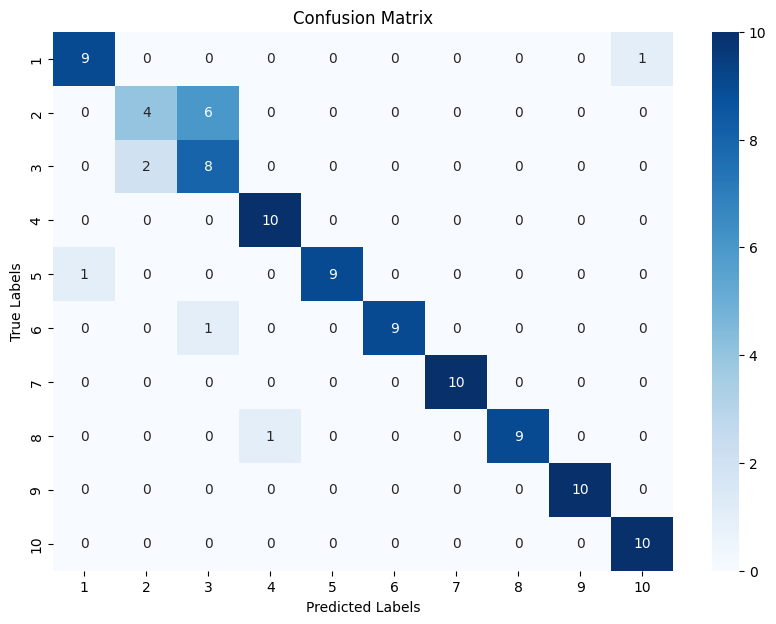

In [85]:
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [74]:
def get_predictions(video_path, class_names, lstm_model, device):
    frame_numbers= 30
    vid_idx_to_class_name= {i+1:label for i, label in enumerate(class_names)}
    with mp.solutions.holistic.Holistic(min_detection_confidence= 0.5, min_tracking_confidence=0.5) as holistic:
        cap = cv2.VideoCapture(video_path)              # Read each video using cv2
        if not cap.isOpened():                          # if cv2 can't read the video
            print("unable to read the video")
            return
        else:                                           # if cap can read the video
            total_frames_number = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))                                # getting the total frames in video
            frame_idxs_to_process = np.linspace(0, total_frames_number-1, frame_numbers, dtype=int)     # picking desiered frame indexes
            video_detections= []
            for idx in frame_idxs_to_process:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame= cap.read()
            
                result= holistic.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
                pose= np.array([[res.x, res.y, res.z, res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4) 
                face= np.array([[res.x, res.y, res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3) 
                #lh= np.array([[res.x, res.y, res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
                rh= np.array([[res.x, res.y, res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
                detection= np.concatenate((pose, face, rh))
                label= vid_idx_to_class_name[int(os.path.basename(video_path).split('_')[0])]
                video_detections.append(detection)
                input_tensor = torch.tensor([video_detections], dtype=torch.float32).to(device)

            lstm_model.eval()

            # Make a prediction
            with torch.no_grad():
                output = lstm_model(input_tensor)
                    
            # Assuming the output is logits and this is a classification task
            # Convert logits to probabilities and determine the predicted class
            probabilities = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1)
            predicted_class = predicted_class.item()
            predicted_class = class_names[predicted_class]


            print(f"Predicted Class: {predicted_class}, label: {label}")
            cap.release()

In [77]:
video_path= 'lsa64_raw/some/001_001_001.mp4'

In [78]:
get_predictions(video_path, class_names, lstm_model, device)

Predicted Class: Opaque, label: Opaque
